# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [18]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  print X_train.shape
  print X_test.shape

  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]

  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
    
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

print X_train[0,0:4,0:4,:]

(50000, 32, 32, 3)
(10000, 32, 32, 3)
[[[  59.   62.   63.]
  [  43.   46.   45.]
  [  50.   48.   43.]
  [  68.   54.   42.]]

 [[  16.   20.   20.]
  [   0.    0.    0.]
  [  18.    8.    0.]
  [  51.   27.    8.]]

 [[  25.   24.   21.]
  [  16.    7.    0.]
  [  49.   27.    8.]
  [  83.   50.   23.]]

 [[  33.   25.   17.]
  [  38.   20.    4.]
  [  87.   54.   25.]
  [ 106.   63.   28.]]]


## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

HOG特征：<br/>
1.简介
HOG（Histogram of Oriented Gradient）是2005年CVPR会议上，法国国家计算机科学及自动控制研究所的Dalal等人提出的一种解决人体目标检测的图像描述子，该方法使用梯度方向直方图（Histogram of Oriented Gradients,简称HOG）特征来表达人体，提取人体的外形信息和运动信息，形成丰富的特征集。主要用在object detection 领域，特别是行人检测，智能交通系统，当然也有文章提到把HOG用在手势识别，人脸识别等方面。

2.生成过程 (代码：cs231n.features.hog_feature)
![](hog\HOG1.png)

1）图像归一化<br/>
归一化图像的主要目的是提高检测器对光照的鲁棒性，因为实际的人体目标可能出现的各种不同的场合，检测器必须对光照不太敏感才会有好的效果。

2)利用一阶微分计算图像梯度<br/>
图像平滑 <br/>
对于灰度图像，一般为了去除噪点，所以会先利用离散高斯平滑模板进行平滑：高斯函数在不同平滑的尺度下进行对灰度图像进行平滑操作，Dalal等实验表明在下，人体检测效果最佳（即不做高斯平滑），使得错误率缩小了约一倍。不做平滑操作，可能原因：图像时基于边缘的，平滑会降低边缘信息的对比度，从而减少图像中的信号信息。

梯度法求图像梯度<br/>
计算图像横坐标和纵坐标方向的梯度，并据此计算每个像素位置的梯度方向值；求导操作不仅能够捕获轮廓，人影和一些纹理信息，还能进一步弱化光照的影响。一阶微分处理一般对灰度阶梯有较强的响应。
一阶微分：
$$\frac{\partial f}{\partial x} = f(x+1)-f(x)$$
<b>本例中采用的是这种方法计算梯度.</b>

另一种计算梯度的方法是：首先用[-1,0,1]梯度算子对原图像做卷积运算，得到x方向（水平方向，以向右为正方向）的梯度分量gradscalx，然后用[1,0,-1]T梯度算子对原图像做卷积运算，得到y方向（竖直方向，以向上为正方向）的梯度分量gradscaly。然后再用以上公式计算该像素点的梯度大小和方向。<br/>
对于图像像素点(x,y)的梯度为：
$$
G_x(x,y) = f(x+1,y) - f(x-1,y) \\
G_y(x,y) = f(x,y+1) - f(x,y-1)
$$


对于函数f(x,y)，在其坐标（x,y）上的梯度是通过如下二维列向量定义的： <br/>
这个向量的模值由下式给出：
$$\nabla f = 
\begin{bmatrix}
Gx
\\
Gy
\end{bmatrix}
=
\begin{bmatrix}
\frac{\partial f}{\partial x}
\\
\frac{\partial f}{\partial y}
\end{bmatrix}
$$

$G_x(x,y)$，$G_y(x,y)$和$f(x,y)$分别表示图像中的像素点$(x,y)$的水平方向梯度、垂直方向梯度和像素值。
像素点$(x,y)$处的梯度幅值和梯度方向分别为：
$$
\|G(x,y)\|_2 = \sqrt{G_x(x,y)^2 + G_y(x,y)^2}
\\
\alpha(x,y) = acrtan\left(\frac{G_y(x,y)}{G_x(x,y)}\right)
$$
根据计算的梯度是否有正负之分, 可以把方向定为 (0~180) 或者 (0~360).<br/>
<b>本例中采用的是0~180度.</b>

3)基于梯度幅值的方向权重投影<br/>
通常使用的HOG结构大致有三种：矩形HOG（简称为R-HOG），圆形HOG和中心环绕HOG。它们的单位都是Block（即块）。Dalal的试验证明矩形HOG和圆形HOG的检测效果基本一致，而环绕形HOG效果相对差一些。
![](hog\HOG2.png)

矩形HOG块的划分：<br/>
一般一个块（Block）都由若干单元（Cell）组成，一个单元都有如干个像素点组成。
![](hog\HOG3.png)


在每个Cell中有独立做梯度方向统计，从而以梯度方向为横轴的的直方图，前面我们已经提到过，梯度方向可取0度~180度或0度~360度，但dalal实验表明，对于人体目标检测0度~180度这种忽略度数正负级的方向范围能够取得更好的结果。以20度作为一个bin（就是直方图里的一个竖条），可以构成含有9个bin的直方图。作者将图像划分成了一个个小的cell，每个cell里包含4x4,6x6...个像素，以每个cell做为一个单元，这样每个cell就能得到一个统计直方图。这样就相当于保留了图像局部的特征。经过试验发现，6x6大小的cell效果最好，如下图（先忽略block）。
![](hog\HOG4.png)

&emsp;&emsp; 在将梯度的方向放到bin里时，根据梯度值的不同对bin的贡献也应该不同，比如可以将梯度值开方平方等等。经过测试作者发现最简单的才是最有效的，比如某个像素的梯度值为10，方向为15度，那就将0-20度的bin加10就好了。

4)HOG特征向量归一化<br/>
对block块内的HOG特征向量进行归一化。对block块内特征向量的归一化主要是为了使特征向量空间对光照，阴影和边缘变化具有鲁棒性。还有归一化是针对每一个block进行的，一般采用的归一化函数有以下四种：
![](hog\HOG5.png)
在人体检测系统中进行HOG计算时一般使用L2-norm，Dalal的文章也验证了对于人体检测系统使用L2-norm的时候效果最好。

5）收集HOG特征<br/>
最后一步就是将检测窗口中所有重叠的块进行HOG特征的收集，并将它们结合成最终的特征向量供分类使用。

In [49]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
# feature_fns放的是hog_feature(),color_histogram_hsv()两个函数
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

[<function hog_feature at 0x7f5a15b488c0>, <function <lambda> at 0x7f5a15b846e0>]
Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features fo

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [50]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-7,5e-8]
regularization_strengths = [1e5, 2e5]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=lr, reg=rs,num_iters=1000, verbose=True)
        
        train_labels = svm.predict(X_train_feats)
        train_accuracy = np.mean(train_labels == y_train)
        
        val_labels =svm.predict(X_val_feats)
        val_accuracy = np.mean(val_labels == y_val)
        
        results[(lr,rs)] = (train_accuracy, val_accuracy)
        
        if best_val < val_accuracy:
            best_val = val_accuracy
            best_svm = svm


################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 1000: loss 81.683586
iteration 100 / 1000: loss 18.742976
iteration 200 / 1000: loss 10.305600
iteration 300 / 1000: loss 9.173785
iteration 400 / 1000: loss 9.022986
iteration 500 / 1000: loss 9.002805
iteration 600 / 1000: loss 9.000108
iteration 700 / 1000: loss 8.999699
iteration 800 / 1000: loss 8.999750
iteration 900 / 1000: loss 8.999694
iteration 0 / 1000: loss 155.987019
iteration 100 / 1000: loss 11.585870
iteration 200 / 1000: loss 9.045413
iteration 300 / 1000: loss 9.000626
iteration 400 / 1000: loss 8.999847
iteration 500 / 1000: loss 8.999859
iteration 600 / 1000: loss 8.999846
iteration 700 / 1000: loss 8.999825
iteration 800 / 1000: loss 8.999800
iteration 900 / 1000: loss 8.999838
iteration 0 / 1000: loss 84.496186
iteration 100 / 1000: loss 36.705599
iteration 200 / 1000: loss 19.162851
iteration 300 / 1000: loss 12.729804
iteration 400 / 1000: loss 10.368184
iteration 500 / 1000: loss 9.502574
iteration 600 / 1000: loss 9.184366
iteration 700 / 1000: l

In [51]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.42


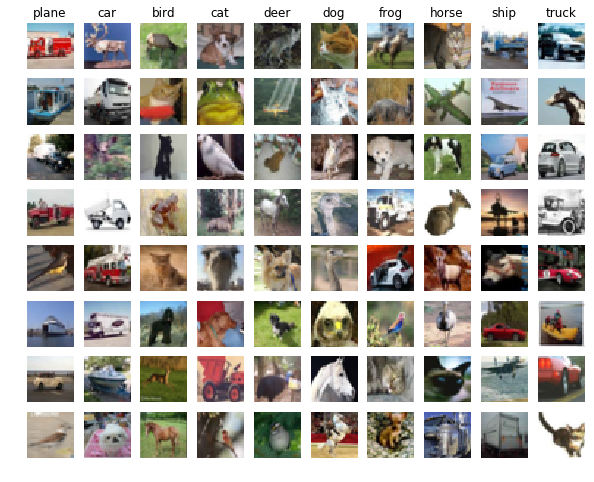

In [52]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?
**Your answer:**
1. Their background seems the same as real class background.
2. Some misclassfied object has similar shape as real class.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [8]:
print X_train_feats.shape

(49000, 155)


In [33]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
best_val_acc = 0
results = {}

learning_rates = [1e-1, 5e-1]
regularization_strengths=[1e-3, 1e-5]
for lr in learning_rates:
    for rs in regularization_strengths:
        
        net.train(X_train_feats, y_train, X_val_feats, y_val,
                    learning_rate=lr , learning_rate_decay=0.95,
                    reg=rs, num_iters=1500,
                    batch_size=200, verbose=False)

        y_train_labels = net.predict(X_train_feats)
        train_acc = np.mean(y_train_labels == y_train)
        
        y_val_labels = net.predict(X_val_feats)
        val_acc = np.mean(y_val_labels == y_val)
        
        results[(lr, rs)] = (train_acc, val_acc)
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_net = net

for lr, rs in sorted(results):
    acc = results[(lr,rs)]
    print "lr:%e rs:%e train accuracy:%e validation accuracy:%e" \
           %(lr, rs, acc[0], acc[1])

print "best val accuracy:%s" %(best_val_acc)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 1500: loss 2.302586
iteration 100 / 1500: loss 2.301895
iteration 200 / 1500: loss 2.122476
iteration 300 / 1500: loss 1.813702
iteration 400 / 1500: loss 1.683622
iteration 500 / 1500: loss 1.500137
iteration 600 / 1500: loss 1.309110
iteration 700 / 1500: loss 1.398797
iteration 800 / 1500: loss 1.463433
iteration 900 / 1500: loss 1.466235
iteration 1000 / 1500: loss 1.381733
iteration 1100 / 1500: loss 1.412920
iteration 1200 / 1500: loss 1.431344
iteration 1300 / 1500: loss 1.353791
iteration 1400 / 1500: loss 1.321031
iteration 0 / 1500: loss 1.249177
iteration 100 / 1500: loss 1.280615
iteration 200 / 1500: loss 1.304405
iteration 300 / 1500: loss 1.242557
iteration 400 / 1500: loss 1.205587
iteration 500 / 1500: loss 1.154845
iteration 600 / 1500: loss 1.259911
iteration 700 / 1500: loss 1.170036
iteration 800 / 1500: loss 1.280368
iteration 900 / 1500: loss 1.378530
iteration 1000 / 1500: loss 1.238524
iteration 1100 / 1500: loss 1.231951
iteration 1200 / 1500: lo

In [34]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print test_acc

0.58


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!